# Data  loading

<pre>
1. Download all the data in this folder https://drive.google.com/open?id=1Z4TyI7FcFVEx8qdl4jO9qxvxaqLSqoEu. it contains two file both images and labels. The label file list the images and their categories in the following format:
            <b>path/to/the/image.tif,category</b>
            
    where the categories are numbered 0 to 15, in the following order:

    <b>0 letter
    1 form
    2 email
    3 handwritten
    4 advertisement
    5 scientific report
    6 scientific publication
    7 specification
    8 file folder
    9 news article
    10 budget
    11 invoice
    12 presentation
    13 questionnaire
    14 resume
    15 memo</b>
    
2. On this image data, you have to train 3 types of models as given below. You have to split the data into Train and Validation data.

3. Try not to load all the images into memory, use the gernarators that we have given the reference notebooks to load the batch of images only during the train data.
or you can use this method also
<a href='https://medium.com/@vijayabhaskar96/tutorial-on-keras-imagedatagenerator-with-flow-from-dataframe-8bd5776e45c1'>https://medium.com/@vijayabhaskar96/tutorial-on-keras-imagedatagenerator-with-flow-from-dataframe-8bd5776e45c1</a>

<a href='https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c'>https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c</a>


4. You are free to choose Learning rate, optimizer, loss function, image augmentation, any hyperparameters. but you have to use the same architechture what we are asking below. 

5. Use tensorboard for every model and analyse your gradients. (you need to upload the screenshots for each model for evaluation)

Note: fit_genarator() method will have problems with the tensorboard histograms, try to debug it, if you could not do use histgrams=0 i.e don't include histograms, check the documentation of tensorboard for more information. 

6. You can check about Transfer Learning in this link - <a href='https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html'>https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html</a>
</pre>

In [1]:
import tensorflow as tf

import pandas as pd
import numpy as np

import os

import matplotlib.pyplot as plt

In [2]:
data_dir = os.path.join('.', 'JPG_DATA')
data_dir

'.\\JPG_DATA'

In [3]:
df = pd.read_csv(os.path.join(data_dir, 'labels_final.csv'))

In [4]:
df.head(3)

,path,label
0,JPG_DATA/data_final/imagesv/v/o/h/voh71d00/509...,3
1,JPG_DATA/data_final/imagesl/l/x/t/lxt19d00/502...,3
2,JPG_DATA/data_final/imagesx/x/e/d/xed05a00/207...,2


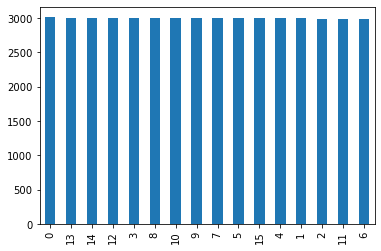

In [5]:
_ = df.label.value_counts().plot(kind='bar')

- No need for stratified sampling 

In [6]:
train_df = df.sample(frac=0.8, random_state=25)
test_df = df.drop(train_df.index)

In [7]:
df.shape, train_df.shape, test_df.shape

((48000, 2), (38400, 2), (9600, 2))

In [8]:
# Create a data set for train and test

In [9]:
train_df.head(2)

,path,label
39848,JPG_DATA/data_final/imagesi/i/s/x/isx37c00/207...,10
32989,JPG_DATA/data_final/imageso/o/h/s/ohs99c00/400...,6


In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
AUTOTUNE

-1

In [11]:
IMAGE_HEIGHT, IMAGE_WIDTH = 156, 256

In [12]:
def prepare_data(df, size, batch_size=32, train=False, cache=False):
    ds = tf.data.Dataset.from_tensor_slices(tensors=(df.path.values, df.label.values))
    
    def get_image_label(file_path, label):
        """ To get the image and label"""
        # decode string to grayscale image
        img = tf.image.decode_jpeg(
            contents=tf.io.read_file(file_path), channels=3)
        img = tf.image.convert_image_dtype(img, dtype=tf.float32)  # convert to float
        img = tf.image.resize(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])

        return img, label
    
    # shuffle the data if the dataset is for training
    if train:
        ds.shuffle(df.shape[0])
    
    # get image as numpy array and labels and create batches
    ds = ds.map(map_func=get_image_label)
    ds = ds.batch(batch_size=batch_size)
    
    # apply cache to the dataset for faster pipelines
    if cache:
        if isinstance(cache, str):  # cache in files
            ds = ds.cache(cache)
        else:  # if all the data can fit in the memory
            ds = ds.cache()
    
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    # prefetch the data
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return ds

In [13]:
BATCH_SIZE=16

In [14]:
train_ds = prepare_data(df=train_df, size=[IMAGE_HEIGHT, IMAGE_WIDTH],
                       batch_size=BATCH_SIZE, train=False, cache='rvl-train.tfcache')

In [15]:
test_ds = prepare_data(df=test_df, size=[IMAGE_HEIGHT, IMAGE_WIDTH],
                       batch_size=BATCH_SIZE, train=True, cache='rvl-test.tfcache')

In [16]:
38400/64

600.0

In [20]:
%%time
train_iter = iter(train_ds)

i = 0
points = 0
for images, label in train_iter:
    i+=1
    points += images.shape[0]
    print(i, points, images.shape, label.shape, end='\r')
print()

KeyboardInterrupt: 

In [19]:
%%time
test_iter = iter(test_ds)

i = 0
points = 0
for images, label in test_iter:
    i+=1
    points += images.shape[0]
    print(i, points, images.shape, label.shape, end='\r')
print()

KeyboardInterrupt: 

# Model-1

<pre>
1. Use <a href='https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16'>VGG-16</a> pretrained network without Fully Connected layers and initilize all the weights with Imagenet trained weights. 
2. After VGG-16 network without FC layers, add a new Conv block ( 1 Conv layer and 1 Maxpooling ), 2 FC layers and a output layer to classify 16 classes. You are free to choose any hyperparameters/parameters of conv block, FC layers, output layer. 
3. Final architecture will be <b>INPUT --> VGG-16 without Top layers(FC) --> Conv Layer --> Maxpool Layer --> 2 FC layers --> Output Layer</b>
4. Train only new Conv block, FC layers, output layer. Don't train the VGG-16 network. 

</pre>

In [17]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, Sequential

In [18]:
from time import perf_counter

#### Create summary writers for this model 

In [19]:
wtrain = tf.summary.create_file_writer(logdir="logs/1_Model1/train")
wtest = tf.summary.create_file_writer(logdir="logs/1_Model1/test")

#### Model definition

In [20]:
class Model1(tf.keras.Model):
    def __init__(self, **kwargs):
        super(Model1, self).__init__(**kwargs)
        # vgg feature layer
        self.feature = VGG16(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3),
                             include_top=False,
                             weights='imagenet')
        
        # VGG16 : to avoid training 
        self.feature.trainable=False
        
        self.conv_block = Sequential(layers=[
            layers.Conv2D(filters=128, kernel_size=3, padding='same'),
            layers.MaxPool2D(pool_size=(2,2))
        ])
        
        self.fc_layer = Sequential(layers=[
            layers.Dense(units=128, activation='relu'),
            layers.Dense(units=16, activation='softmax')
        ])
        
        # initialize configs to None
        self.loss_fn, self.optimizer, self.acc_fn = None, None, None
        
    @tf.function
    def call(self, x):
        # feature representation of the input
        x = self.feature(x)
        x = self.conv_block(x)  # additional conv layers
        
        # flatten the output before passing it to the output layer
        x = tf.reshape(x, shape=[x.shape[0], -1])
        x = self.fc_layer(x)  # softmax outputs
        
        return x

    @property
    def metrics(self):
        return self.metrics_
    
    @metrics.setter
    def metrics(self, metrics):
        self.metrics_ = metrics
    
    def compile(self, loss_fn, optimizer):
        """Initialize loss_fn and the optimizer"""
        self.loss_fn, self.optimizer = loss_fn, optimizer

    def get_config(self):
        """returns: loss function and optimizer and acc_fn for this model"""
        return {
            "loss_fn": self.loss_fn,
            "optimizer": self.optimizer,
            "acc_fn" : self.acc_fn
        }

    @tf.function
    def train_step(self, images, labels, acc_fn=None):
        """return the loss and accuracy before doing back-propagation"""
        # Forward : record all the computations on a tape
        with tf.GradientTape() as tape:
            out = self.call(images)  # softmax outputs
            loss = self.loss_fn(y_true=labels, y_pred=out)
        
        # BackwardProp : calculate and update gradients w.r.t loss (dLoss/dGrad)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(grads_and_vars=zip(gradients, self.trainable_variables))
        
        # find the accuracy if required for this batch
        if acc_fn:
            acc = acc_fn(y_true=labels, y_pred=out)
            return loss, acc
        
        return loss
    
    def validate(self, data, train=False):
        """Updates the metric states for the current dataset"""
        self.reset_metrics()  # reset metrics
        
        for images, labels in data:
            out = self.call(images)
            # update all the metrics
            for metric in self.metrics:
                metric(y_true=labels, y_pred=out)
        
        return [metric.result() for metric in self.metrics]

#### Model initialization

In [21]:
model1 = Model1(name="Model1")
# just to get the model summary
model1.build(input_shape=(1, IMAGE_HEIGHT, IMAGE_WIDTH, 3))
model1.summary()

Model: "Model1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 8, 512)         14714688  
_________________________________________________________________
sequential (Sequential)      multiple                  589952    
_________________________________________________________________
sequential_1 (Sequential)    multiple                  133264    
Total params: 15,437,904
Trainable params: 723,216
Non-trainable params: 14,714,688
_________________________________________________________________


In [22]:
for images, labels in train_ds.take(1):
    out = model1(images)

In [23]:
out.shape

TensorShape([16, 16])

In [24]:
opt = tf.optimizers.Adam(learning_rate=1e-3)
loss_fn = tf.losses.SparseCategoricalCrossentropy()

In [29]:
labels.shape, out.shape

(TensorShape([16]), TensorShape([16, 16]))

In [32]:
loss_fn(labels, out)

<tf.Tensor: id=1087, shape=(), dtype=float32, numpy=3.3050504>

In [33]:
tf.reduce_mean(tf.losses.sparse_categorical_crossentropy(labels, out))

<tf.Tensor: id=1099, shape=(), dtype=float32, numpy=3.3050504>

In [23]:
model1.compile(loss_fn=loss_fn, optimizer=opt)
model1.metrics = [tf.metrics.SparseCategoricalCrossentropy(),
                  tf.metrics.SparseCategoricalAccuracy()]

#### Creating & loading check points for this model

In [24]:
model1_ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=model1.optimizer, net=model1)
model1_ckpt_manager = tf.train.CheckpointManager(model1_ckpt, './model1_tf_ckpts', max_to_keep=3)

In [32]:
model1_ckpt.step.assign(model1.optimizer.iterations.numpy())

<tf.Variable 'UnreadVariable' shape=() dtype=int32, numpy=0>

In [36]:
# load the model check point
model1_ckpt.restore(model1_ckpt_manager.latest_checkpoint)

if model1_ckpt_manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
     print("Initializing from scratch.")

Initializing from scratch.


#### Training

In [37]:
EPOCHS = 5
log_freq = 10
val_log_freq = 100
ckpt_freq = 100

train_params = {'loss':[], 'accuracy': [], 'epoch':[]}
val_params = {'loss':[], 'accuracy': [], 'epoch':[]}
loss_arr = []  # this is for every iteration

acc_fn = tf.metrics.SparseCategoricalAccuracy()  # for per step accuracy
global_st = perf_counter()

for epoch in range(EPOCHS):
    local_st = perf_counter()
    # acc_fn.reset_states() #-not required. Caling below for evert val_log_freq
    
    for images, labels in train_ds:
        loss, acc = model1.train_step(images, labels, acc_fn)
        
        if tf.equal(model1.optimizer.iterations % log_freq, 0):
            with tf.name_scope('training_loss_and_acc'):
                with wtrain.as_default():
                    tf.summary.scalar("loss", loss, step=model1.optimizer.iterations)
                    tf.summary.scalar("acc", acc, step=model1.optimizer.iterations)
                    wtrain.flush()
        
        # store validation loss for every few steps
        if tf.equal(model1.optimizer.iterations % val_log_freq, 0):
            val_loss, val_acc = model1.validate(test_ds)
            with tf.name_scope("Train_Test_validtion"):
                with wtrain.as_default():
                    tf.summary.scalar("loss", loss.numpy(), step=model1.optimizer.iterations)
                    tf.summary.scalar("acc", acc.numpy(), step=model1.optimizer.iterations)
                    wtrain.flush()
                # reset acc_fn. It will be cumulative till end of epoch otherwise.
                acc_fn.reset_states()

                with wtest.as_default():
                    tf.summary.scalar("loss", val_loss.numpy(), step=model1.optimizer.iterations)
                    tf.summary.scalar("acc", val_acc.numpy(), step=model1.optimizer.iterations)
                    wtest.flush()
                    
        # save the model for every ckpt_freq steps
        if tf.equal(model1.optimizer.iterations % ckpt_freq, 0):
            model1_ckpt.step.assign(model1.optimizer.iterations.numpy())
            save_path = manager.save()
            print("Saved checkpoint for step {}: {}".format(int(model1_ckpt.step), save_path))

    # update the params
    train_params['loss'].append(loss.numpy())
    train_params['accuracy'].append(acc.numpy())
    train_params['epoch'].append(epoch+1)
    
    # validating the model after this epoch
    val_loss, val_acc = model1.validate(test_ds)
    val_params['loss'].append(val_loss.numpy())
    val_params['accuracy'].append(val_acc.numpy())
    val_params['epoch'].append(epoch+1)
    
    # write them to the tensorboard
    with tf.name_scope("per_epoch_params"):
        with wtrain.as_default():
            tf.summary.scalar("loss", loss.numpy(), step=epoch+1)
            tf.summary.scalar("acc", acc.numpy(), step=epoch+1)
            wtrain.flush()

        with wtest.as_default():
            tf.summary.scalar("loss", val_loss, step=epoch+1)
            tf.summary.scalar("acc", val_acc, step=epoch+1)
            wtest.flush()
    
    template = "\nEpoch:{}/{} loss:{:0.5f}  acc:{:0.4f}  "
    template += "val_loss:{:0.5f}  val_acc:{:0.4f} - {:0.0f}s(total: {:0.0f}s)"
    print(template.format(epoch+1, EPOCHS,
                      loss.numpy(), acc.numpy(), 
                      val_loss, val_acc,
                      perf_counter()-local_st, perf_counter()-global_st))

AttributeError: 'numpy.float32' object has no attribute 'numpy'

# Model-2

<pre>
1. Use <a href='https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16'>VGG-16</a> pretrained network without Fully Connected layers and initilize all the weights with Imagenet trained weights.
2. After VGG-16 network without FC layers, don't use FC layers, use conv layers only as Fully connected layer. any FC layer can be converted to a CONV layer. This conversion will reduce the No of Trainable parameters in FC layers. For example, an FC layer with K=4096 that is looking at some input volume of size 7×7×512 can be equivalently expressed as a CONV layer with F=7,P=0,S=1,K=4096. In other words, we are setting the filter size to be exactly the size of the input volume, and hence the output will simply be 1×1×4096 since only a single depth column “fits” across the input volume, giving identical result as the initial FC layer. You can refer <a href='http://cs231n.github.io/convolutional-networks/#convert'>this</a> link to better understanding of using Conv layer in place of fully connected layers.
3. Final architecture will be VGG-16 without FC layers(without top), 2 Conv layers identical to FC layers, 1 output layer for 16 class classification. <b>INPUT --> VGG-16 without Top layers(FC) --> 2 Conv Layers identical to FC --> Output Layer</b>
3. Train only last 2 Conv layers identical to FC layers, 1 output layer. Don't train the VGG-16 network. 
</pre>

# Model-3

<pre>
1. Use same network as Model-2 '<b>INPUT --> VGG-16 without Top layers(FC) --> 2 Conv Layers identical to FC --> Output Layer</b>' and train only Last 6 Layers of VGG-16 network, 2 Conv layers identical to FC layers, 1 output layer.
</pre>